In [2]:
%load_ext autoreload
%config Completer.use_jedi = False

In [3]:
%autoreload 2
import FEMOL
import numpy as np
np.set_printoptions(linewidth=200)
np.set_printoptions(suppress=True)
from IPython.display import clear_output
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from scipy.interpolate import interp1d, griddata, interp2d, RectBivariateSpline
import scipy.linalg
import matplotlib.cm as colormaps
import matplotlib.colors
from mpl_toolkits.axes_grid1 import Divider, Size
import meshio
import time
import runpy

# Development Notebook for the FEMOL Project

In [261]:
# Optimization solve
# Solve the eigenvalue maximization problem for the first mode of a square plate

hc_opt = 0.010 # optimized core thickness
h_flax = 0.003
h_carbon = 0.000250
n_plies_carbon = 2
n_plies_flax = 9
problem_mesh = FEMOL.mesh.guitar(lcar=0.04)

# flax material definition
flax = FEMOL.materials.general_flax()  # material from library
flax.hi = h_flax/n_plies_flax
# carbon material definition
carbon = FEMOL.materials.general_carbon()
carbon.hi = h_carbon

# Laminates definitions
h = hc_opt + h_flax + h_carbon
# Reference layups
plies_flax = [0, 0, 0, 0, 0, 0, 0, 0, 0]
flax_layup = FEMOL.laminate.Layup(material=flax, plies=plies_flax, symetric=False, z_core = -h/2 + (n_plies_flax/2)*flax.hi)
plies_carbon = [90, 90]
carbon_layup = FEMOL.laminate.Layup(material=carbon, plies=plies_carbon, symetric=False, z_core = h/2 - (n_plies_carbon/2)*carbon.hi)

# FEM problems definition
problem_opt = FEMOL.FEM_Problem(mesh=problem_mesh, physics='modal', model='plate')
problem_opt.define_materials(flax, carbon)
problem_opt.define_tensors(flax_layup, carbon_layup)
problem_opt.add_fixed_domain(FEMOL.domains.outside_guitar(L=1))

# Solve the reference problem
w_opt, v_opt = problem_opt.solve(filtre=0)


Solving using scipy.linalg.eigh(K, M)
solved in 12.59598708152771 s


In [264]:
modes = ['T11', 'T21', 'T12', 'T31']
eigvecs = [np.load(f'Results/guitar_modes/guitar_mode_{m}_lcar04.npy') for m in modes]

idxs = [np.argmax([FEMOL.utils.MAC(vi, vref) for vi in v_opt]) for vref in eigvecs]
w_opt[idxs]


array([154.27258163, 358.01322234, 241.2501869 , 643.34344726])

dict_keys(['X', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21', 'X22', 'X23', 'X24', 'X25', 'X26', 'X27', 'X28', 'X29', 'X30', 'X31', 'X32', 'X33', 'X34', 'X35', 'X36', 'X37', 'X38', 'X39', 'X40', 'X41', 'X42', 'X43', 'X44', 'X45', 'X46', 'X47', 'X48', 'X49', 'X50', 'X51', 'X52', 'X53', 'X54', 'X55', 'X56', 'X57', 'X58', 'X59', 'X60', 'X61', 'X62', 'X63', 'X64', 'X65', 'X66', 'X67', 'X68', 'X69', 'X70', 'X71', 'X72', 'X73', 'X74', 'X75', 'X76', 'X77', 'X78', 'X79', 'X80', 'X81', 'X82', 'X83', 'X84', 'X85', 'X86', 'X87', 'X88', 'X89', 'X90', 'X91', 'X92', 'X93', 'X94', 'X95', 'X96', 'X97', 'X98', 'X99'])
327


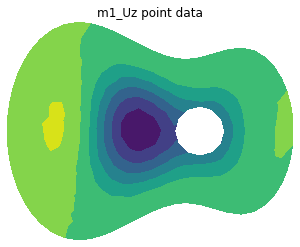

In [267]:
mesh = FEMOL.mesh.load_vtk('meshes_to_check/guitar_lcar05_T11_100_iter.vtk')
print(mesh.cell_data.keys())
print(mesh.N_ele)
mesh.plot.point_data('m1_Uz')

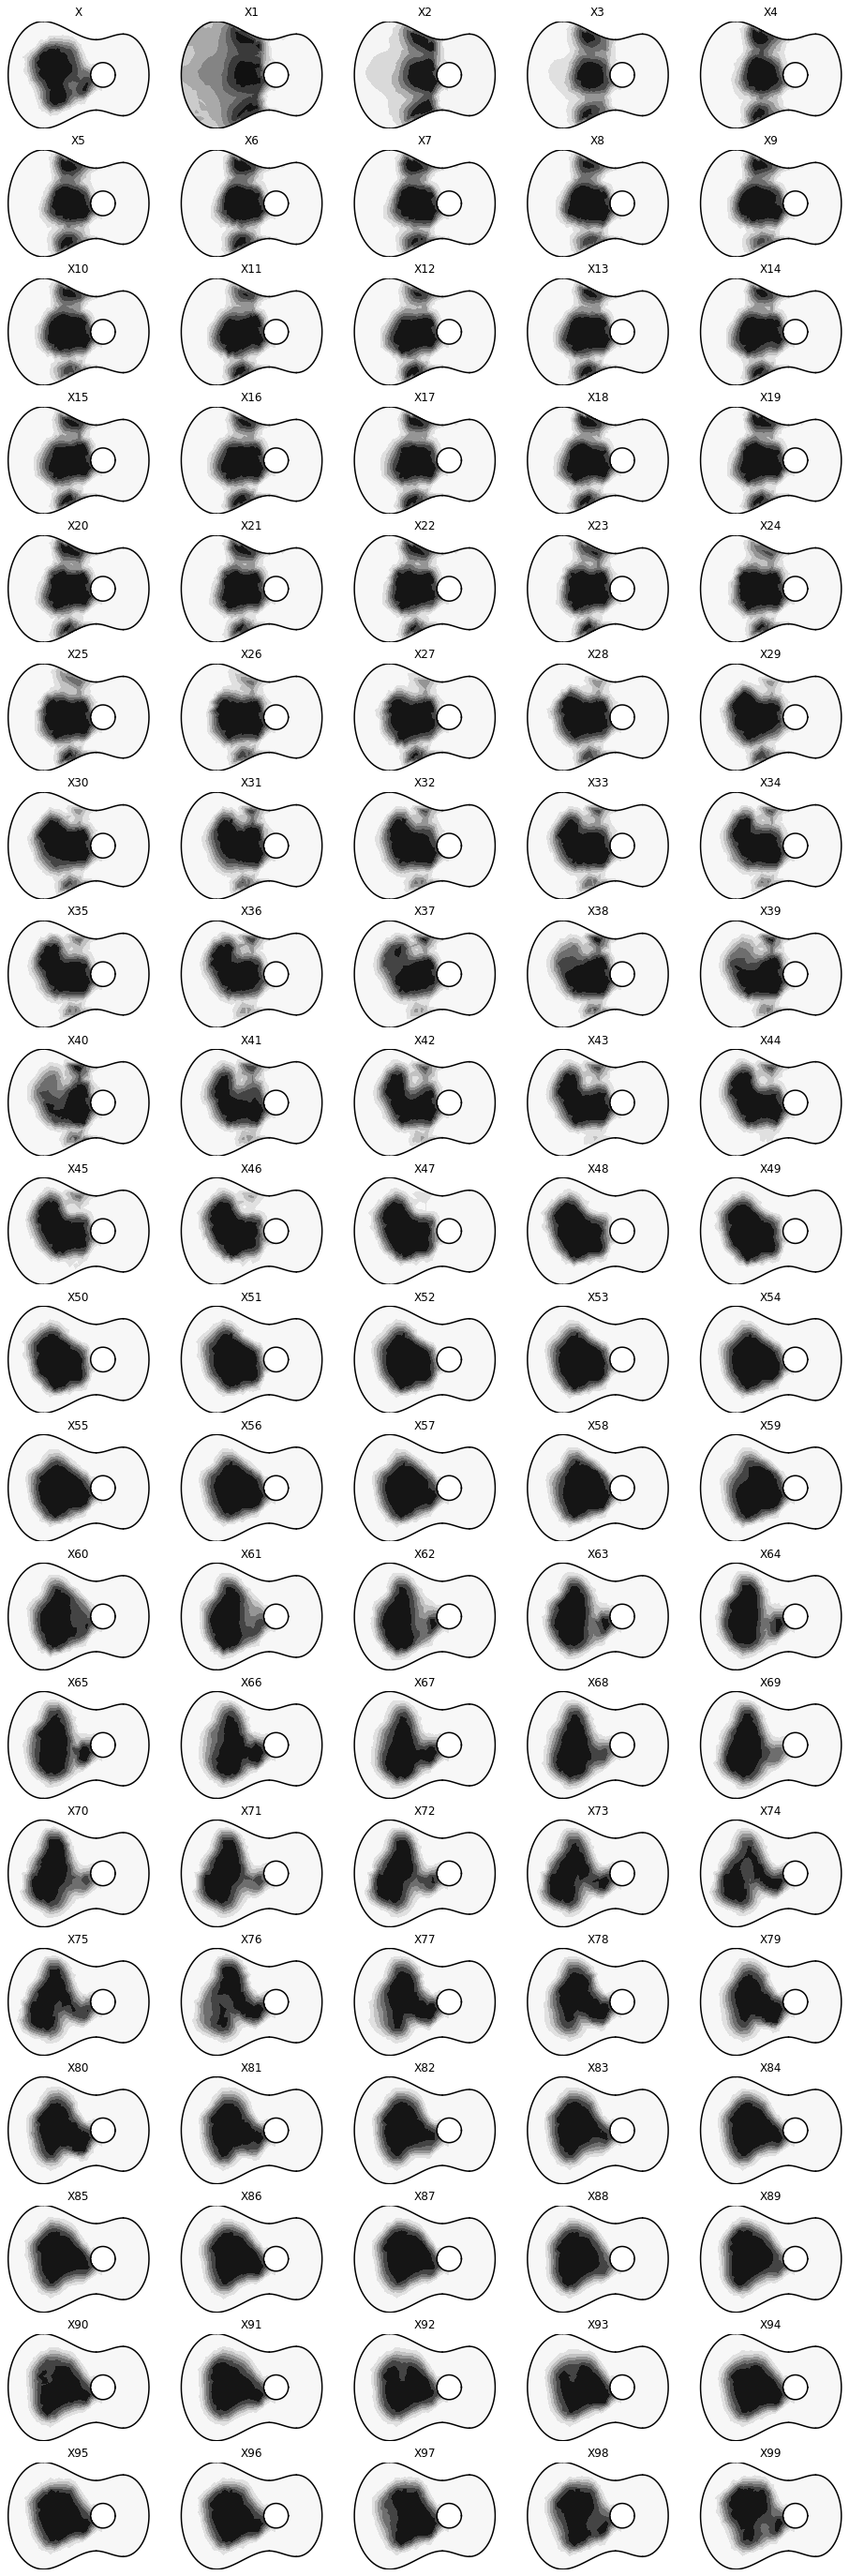

In [268]:
fig, axs = plt.subplots(20, 5, figsize=(16, 50))

for ax, key in zip(axs.flatten(), mesh.cell_data):
    plt.sca(ax)
    mesh.cell_to_point_data(key)
    mesh.plot.point_data(key, cmap='Greys')
    FEMOL.utils.guitar_outline2(L=1)
    ax.set_title(key)

dict_keys(['X', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21', 'X22', 'X23', 'X24', 'X25', 'X26', 'X27', 'X28', 'X29', 'X30', 'X31', 'X32', 'X33', 'X34', 'X35', 'X36', 'X37', 'X38', 'X39', 'X40', 'X41', 'X42', 'X43', 'X44', 'X45', 'X46', 'X47', 'X48', 'X49', 'X50', 'X51', 'X52', 'X53', 'X54', 'X55', 'X56', 'X57', 'X58', 'X59', 'X60', 'X61', 'X62', 'X63', 'X64', 'X65', 'X66', 'X67', 'X68', 'X69', 'X70', 'X71', 'X72', 'X73', 'X74', 'X75', 'X76', 'X77', 'X78', 'X79', 'X80', 'X81', 'X82', 'X83', 'X84', 'X85', 'X86', 'X87', 'X88', 'X89', 'X90', 'X91', 'X92', 'X93', 'X94', 'X95', 'X96', 'X97', 'X98', 'X99'])
327


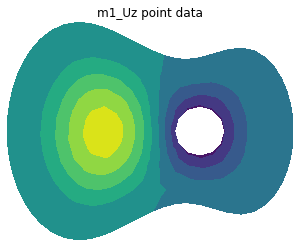

In [269]:
mesh = FEMOL.mesh.load_vtk('meshes_to_check/guitar_lcar05_T21_100_iter.vtk')
print(mesh.cell_data.keys())
print(mesh.N_ele)
mesh.plot.point_data('m1_Uz')

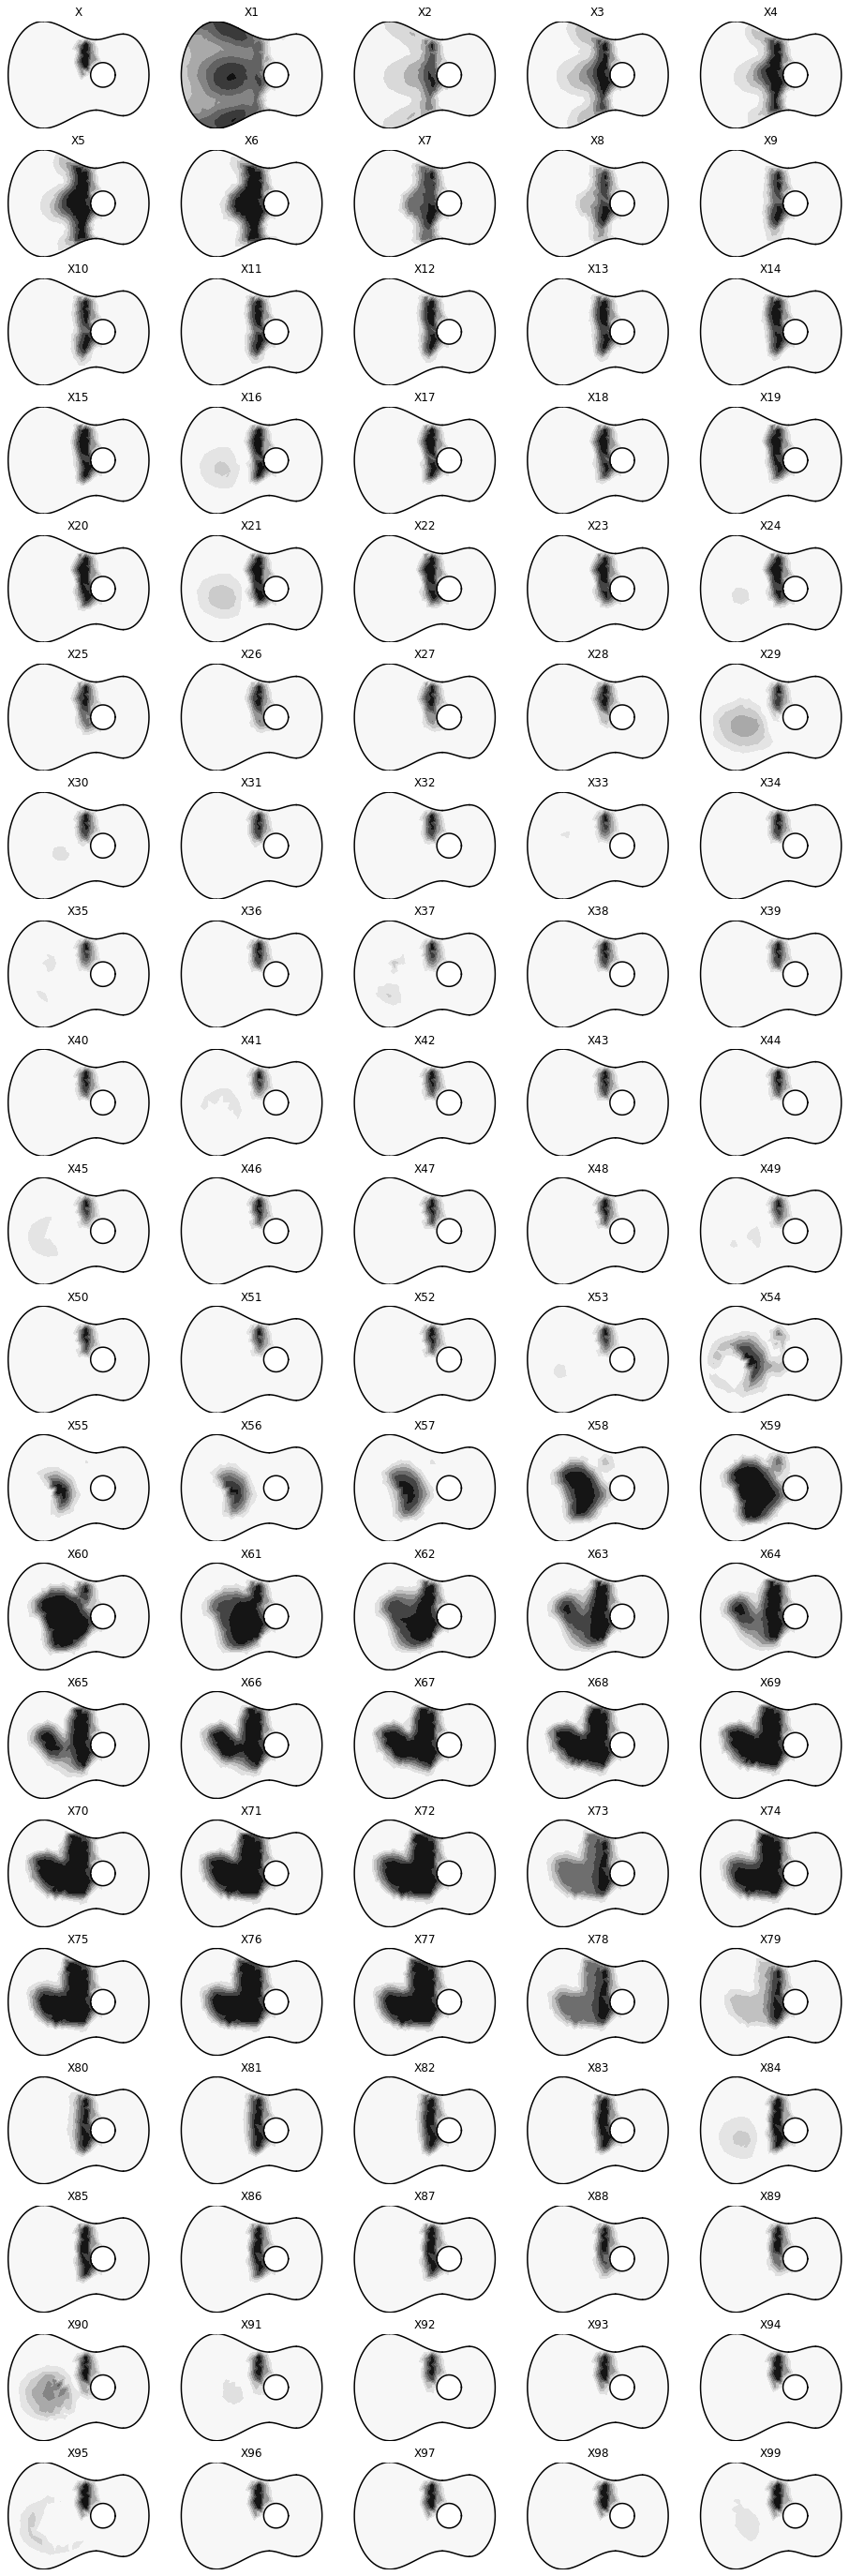

In [270]:
fig, axs = plt.subplots(20, 5, figsize=(16, 50))

for ax, key in zip(axs.flatten(), mesh.cell_data):
    plt.sca(ax)
    mesh.cell_to_point_data(key)
    mesh.plot.point_data(key, cmap='Greys')
    FEMOL.utils.guitar_outline2(L=1)
    ax.set_title(key)

dict_keys(['X', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21', 'X22', 'X23', 'X24', 'X25', 'X26', 'X27', 'X28', 'X29', 'X30', 'X31', 'X32', 'X33', 'X34', 'X35', 'X36', 'X37', 'X38', 'X39', 'X40', 'X41', 'X42', 'X43', 'X44', 'X45', 'X46', 'X47', 'X48', 'X49', 'X50', 'X51', 'X52', 'X53', 'X54', 'X55', 'X56', 'X57', 'X58', 'X59', 'X60', 'X61', 'X62', 'X63', 'X64', 'X65', 'X66', 'X67', 'X68', 'X69', 'X70', 'X71', 'X72', 'X73', 'X74', 'X75', 'X76', 'X77', 'X78', 'X79', 'X80', 'X81', 'X82', 'X83', 'X84', 'X85', 'X86', 'X87', 'X88', 'X89', 'X90', 'X91', 'X92', 'X93', 'X94', 'X95', 'X96', 'X97', 'X98', 'X99'])
327


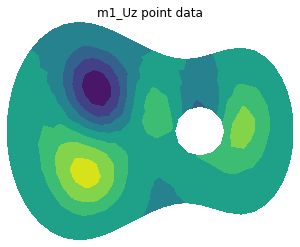

In [271]:
mesh = FEMOL.mesh.load_vtk('meshes_to_check/guitar_lcar05_T21_100_iter.vtk')
print(mesh.cell_data.keys())
print(mesh.N_ele)
mesh.plot.point_data('m1_Uz')

In [ ]:
fig, axs = plt.subplots(20, 5, figsize=(16, 50))

for ax, key in zip(axs.flatten(), mesh.cell_data):
    plt.sca(ax)
    mesh.cell_to_point_data(key)
    mesh.plot.point_data(key, cmap='Greys')
    FEMOL.utils.guitar_outline2(L=1)
    ax.set_title(key)

In [ ]:
mesh = FEMOL.mesh.load_vtk('meshes_to_check/guitar_lcar05_T13_100_iter.vtk')
print(mesh.cell_data.keys())
print(mesh.N_ele)
mesh.plot.point_data('m1_Uz')

In [ ]:
fig, axs = plt.subplots(20, 5, figsize=(16, 50))

for ax, key in zip(axs.flatten(), mesh.cell_data):
    plt.sca(ax)
    mesh.cell_to_point_data(key)
    mesh.plot.point_data(key, cmap='Greys')
    FEMOL.utils.guitar_outline2(L=1)
    ax.set_title(key)

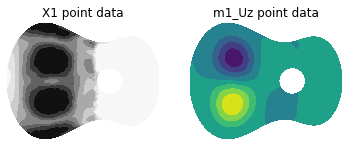

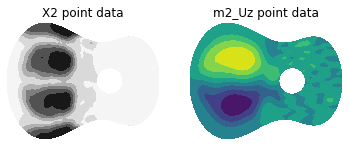

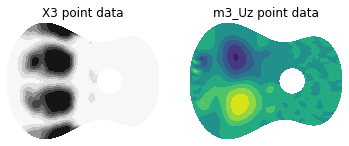

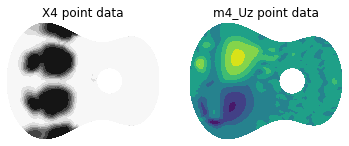

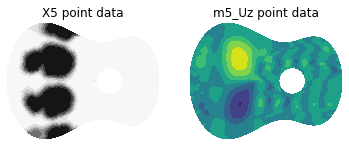

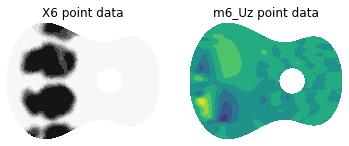

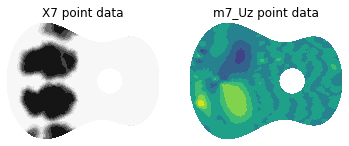

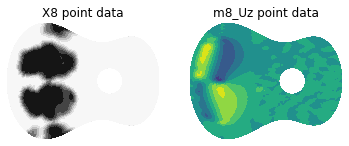

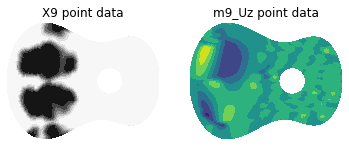

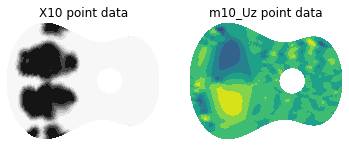

In [146]:

mesh_T21 = FEMOL.mesh.load_vtk('guitar_lcar02_modeT21_10_iter.vtk')
plot_all_TOM(mesh_T21)


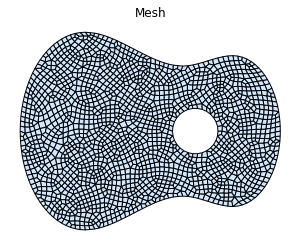

In [40]:
mesh.display()

dict_keys(['X'])


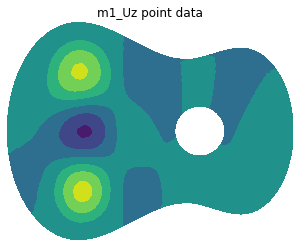

In [39]:
mesh = FEMOL.mesh.load_vtk('TOM_2022-03-20_11_21_39.vtk')
print(mesh.cell_data.keys())
mesh.plot.point_data('m1_Uz')

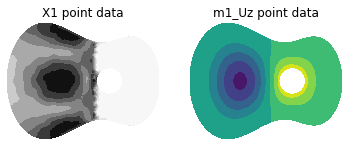

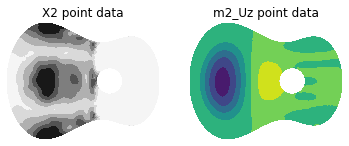

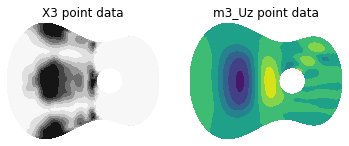

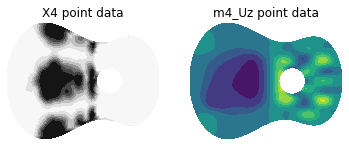

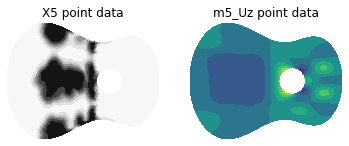

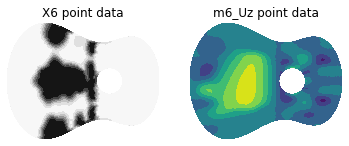

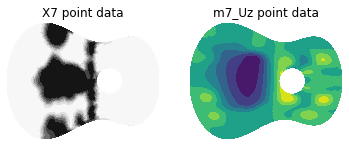

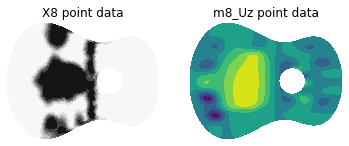

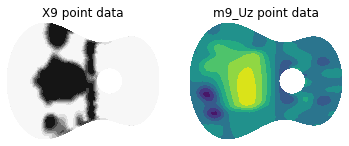

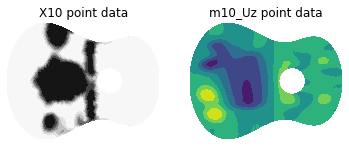

In [157]:
mesh_T12 = FEMOL.mesh.load_vtk('guitar_lcar02_modeT11_10_iter.vtk')
plot_all_TOM(mesh_T12)

In [41]:
np.load('guitar_02/eigen_values_lcar02_T12_2022-03-18_21_31_19.npy')

array([0.23630533, 0.37232311, 0.42911139, 0.39410198, 0.35507405, 0.39517862, 0.40421341, 0.40768584, 0.41032771, 0.41379448])

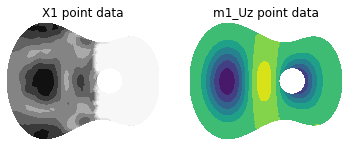

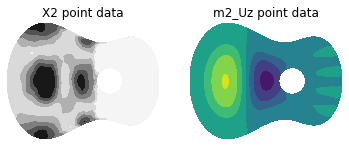

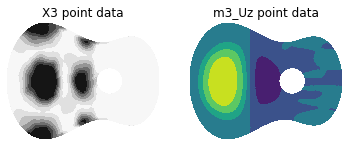

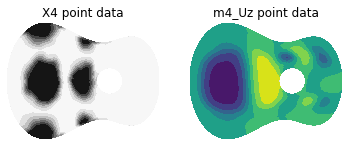

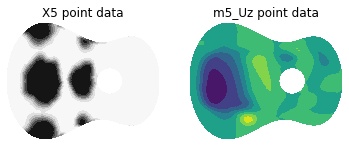

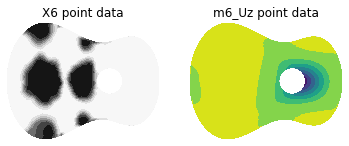

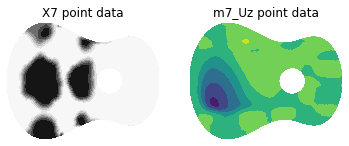

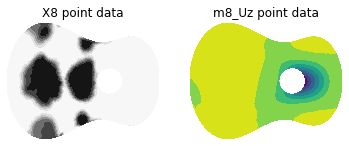

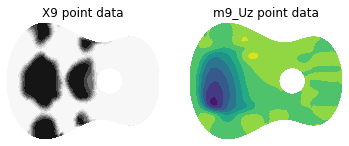

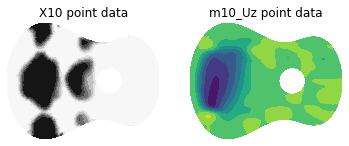

In [156]:
mesh_T13 = FEMOL.mesh.load_vtk('TOM_2022-03-19_16_44_15.vtk')
plot_all_TOM(mesh_T13)